## Rolling 97.5% ES calculation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parameters ---
WINDOW = 252
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# --- Load Data ---
DATA_DIR = "data"
portfolio_returns_path = os.path.join(DATA_DIR, "portfolio_log_returns.csv")
# Load as a DataFrame initially
returns_df = pd.read_csv(portfolio_returns_path, index_col='Date', parse_dates=True)
# Select the Series for calculations
returns_series = returns_df['EqualWeightPortfolio']
print("Successfully loaded portfolio returns.")

Successfully loaded portfolio returns.


### Historical ES

Calculating rolling Historical ES (97.5%)...

✅ Historical ES calculation complete.
Preview:
Date
2008-04-10   -0.025539
2008-04-11   -0.027030
2008-04-14   -0.027030
2008-04-15   -0.027030
2008-04-16   -0.027030
Name: HistES_97.5, dtype: float64


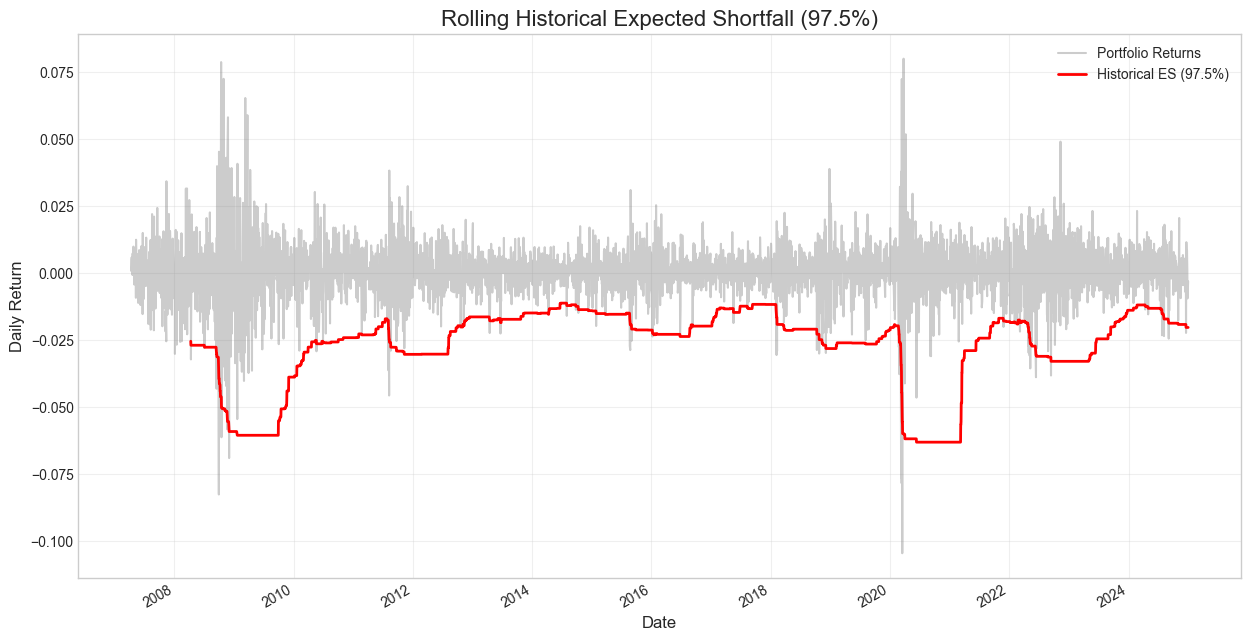

In [5]:
# --- Calculate Rolling Historical ES ---
print("Calculating rolling Historical ES (97.5%)...")
rolling_returns_series = returns_series.rolling(window=WINDOW)

# Calculate the rolling 97.5% VaR (needed as the threshold for ES)
# This will be a Series
historical_var_975_series = returns_series.rolling(window=WINDOW).quantile(ES_ALPHA)

# --- CORRECTED LAMBDA FUNCTION ---
# x is now a Series (the window), compare it directly to the scalar VaR
historical_es_975 = rolling_returns_series.apply(
    lambda x: x[x < historical_var_975_series.loc[x.index[-1]]].mean(),
    raw=False # Use raw=False for correct indexing with .loc
).rename('HistES_97.5') # Rename the resulting Series directly

# Drop initial NaNs
historical_es_975.dropna(inplace=True)

print("\n✅ Historical ES calculation complete.")
print("Preview:")
print(historical_es_975.head())

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

returns_series.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
historical_es_975.plot(ax=ax, color='red', linewidth=2, label='Historical ES (97.5%)') # Plot Series directly

ax.set_title('Rolling Historical Expected Shortfall (97.5%)', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

hist_es = historical_es_975 # Save the resulting Series

### Parametric t-distribution ES

Calculating rolling Parametric ES (t-Dist) (97.5%)...


100%|██████████| 4211/4211 [04:13<00:00, 16.59it/s]



✅ Parametric ES (t-Dist) calculation complete.
Preview:
Date
2008-04-10   -0.027714
2008-04-11   -0.028725
2008-04-14   -0.028629
2008-04-15   -0.028654
2008-04-16   -0.028669
Name: ParamT_ES_97.5, dtype: float64


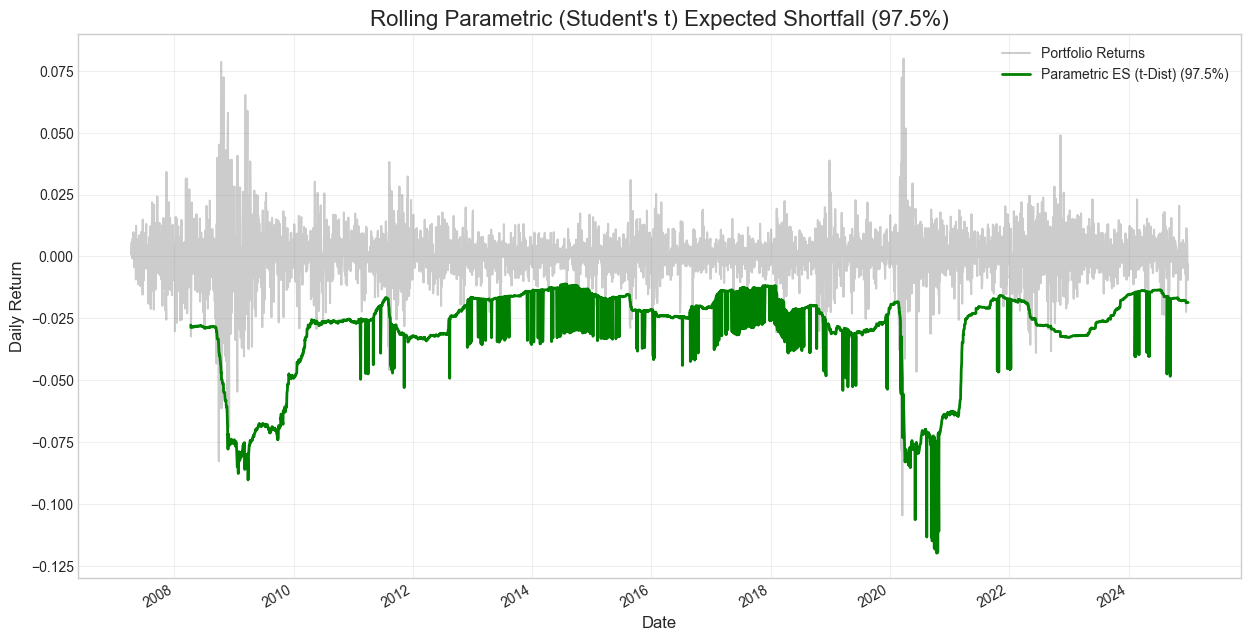

In [6]:
from scipy.stats import t
from tqdm import tqdm

# --- Define Helper Function for t-Distribution ES ---
def get_t_es(returns_window, alpha=ES_ALPHA):
    """Fits a t-distribution and calculates ES."""
    try:
        # Fit the t-distribution to the window of returns
        params = t.fit(returns_window)
        df, loc, scale = params
        
        # Calculate ES using the fitted parameters
        # Get the VaR quantile needed for the ES formula
        t_stat_at_alpha = t.ppf(alpha, df)
        
        # Standard formula for ES of a t-distribution
        es_975 = loc - scale * ( (df + t_stat_at_alpha**2)/(df - 1) ) * ( t.pdf(t_stat_at_alpha, df) / alpha )
        
        # Add safety check for extreme low df values
        if df <= 1:
            return np.nan # ES is not defined for df <= 1
            
        return es_975
    except Exception:
        # Fallback if fitting fails (e.g., use historical ES for the window)
        var_thresh = np.percentile(returns_window, alpha * 100)
        return np.mean(returns_window[returns_window < var_thresh])


# --- Calculate Rolling Parametric ES (t-Distribution) ---
print("Calculating rolling Parametric ES (t-Dist) (97.5%)...")
returns_np = returns_series.to_numpy()
results_list = []
result_index = returns_series.index[WINDOW-1:]

for i in tqdm(range(len(returns_np) - WINDOW + 1)):
    window = returns_np[i : i + WINDOW]
    results_list.append(get_t_es(window))

# Convert the list of results into a DataFrame
param_t_es_975 = pd.Series(results_list, index=result_index, name='ParamT_ES_97.5')

# Drop any NaNs that might have occurred from fallbacks or low df
param_t_es_975.dropna(inplace=True)

print("\n✅ Parametric ES (t-Dist) calculation complete.")
print("Preview:")
print(param_t_es_975.head())

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

returns_series.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
param_t_es_975.plot(ax=ax, color='green', linewidth=2, label='Parametric ES (t-Dist) (97.5%)')

ax.set_title("Rolling Parametric (Student's t) Expected Shortfall (97.5%)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

param_t_es = param_t_es_975 

### GJR GARCH ES

✅ Setup complete. Portfolio returns are loaded.

Calculating rolling GJR-GARCH ES (97.5%)...


100%|██████████| 4210/4210 [02:50<00:00, 24.76it/s]



✅ GJR-GARCH ES calculation complete.
Preview:
2008-04-11   -0.024504
2008-04-14   -0.040598
2008-04-15   -0.039035
2008-04-16   -0.037317
2008-04-17   -0.036118
Name: GJR_ES_97.5, dtype: float64


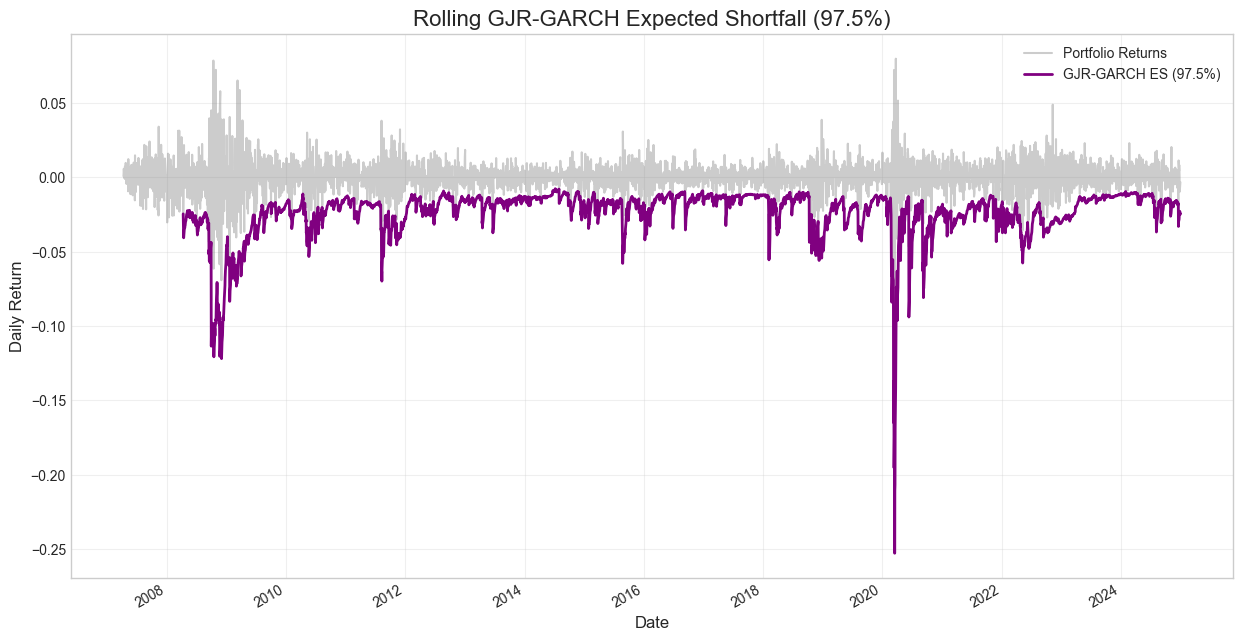

In [7]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- 1. Setup ---
DATA_DIR = "data"
WINDOW = 252
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# Load portfolio returns
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']
print("✅ Setup complete. Portfolio returns are loaded.")

# --- 2. GJR-GARCH Model Fitting Function ---
# (Using your robust fit_gjr_garch_model function)
def fit_gjr_garch_model(returns_window):
    """Fits a GJR-GARCH(1,1) model with a Student's t-distribution."""
    try:
        model = arch_model(
            returns_window * 100,
            vol='Garch', p=1, o=1, q=1,
            mean='Constant', dist='t'
        )
        fit = model.fit(disp='off')
        if not fit.convergence_flag:
            return fit, True
        else:
            return None, False
    except Exception:
        return None, False

# --- 3. Define Helper Function for FHS ES Calculation ---
def calculate_fhs_es(window_returns, garch_fit_obj, alpha=ES_ALPHA):
    """Calculates ES using GARCH fit and empirical residuals."""
    if garch_fit_obj is None: # Handle fallback case
        var_thresh = window_returns.quantile(alpha)
        # Ensure there are returns below threshold before calculating mean
        tail_returns = window_returns[window_returns < var_thresh]
        return tail_returns.mean() if not tail_returns.empty else np.nan

    # Forecast mean and volatility
    forecast = garch_fit_obj.forecast(horizon=1)
    cond_mean = forecast.mean.iloc[-1, 0] / 100
    cond_vol = np.sqrt(forecast.variance.iloc[-1, 0]) / 100

    # Get standardized residuals
    std_resid = gjr_garch_fit.resid / gjr_garch_fit.conditional_volatility
    
    # Calculate the VaR quantile from the residuals
    var_quantile_resid = std_resid.quantile(alpha)
    
    # Calculate ES based on residuals worse than the VaR quantile
    tail_residuals = std_resid[std_resid < var_quantile_resid]
    es_resid = tail_residuals.mean() if not tail_residuals.empty else np.nan
    
    # Final ES = E[ret] + sqrt(E[vol]) * ES_of_std_resid
    es_975 = cond_mean + cond_vol * es_resid
    return es_975

# --- 4. Calculate Rolling GJR-GARCH ES ---
gjr_es_results = []
gjr_dates = []
print("\nCalculating rolling GJR-GARCH ES (97.5%)...")
for i in tqdm(range(WINDOW, len(portfolio_returns))):
    window = portfolio_returns.iloc[i-WINDOW:i]
    current_date = portfolio_returns.index[i]
    
    gjr_garch_fit, success = fit_gjr_garch_model(window)
    
    if success:
        es_val = calculate_fhs_es(window, gjr_garch_fit, alpha=ES_ALPHA)
    else:
        # Fallback to historical ES if GARCH fails
        var_thresh = window.quantile(ES_ALPHA)
        tail_returns = window[window < var_thresh]
        es_val = tail_returns.mean() if not tail_returns.empty else np.nan

    gjr_es_results.append(es_val)
    gjr_dates.append(current_date)

# Create the final Series
gjr_es_975 = pd.Series(gjr_es_results, index=gjr_dates, name='GJR_ES_97.5')

# Drop any NaNs that might have occurred
gjr_es_975.dropna(inplace=True)

print("\n✅ GJR-GARCH ES calculation complete.")
print("Preview:")
print(gjr_es_975.head())

# --- 5. Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

portfolio_returns.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
gjr_es_975.plot(ax=ax, color='purple', linewidth=2, label='GJR-GARCH ES (97.5%)')

ax.set_title("Rolling GJR-GARCH Expected Shortfall (97.5%)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

gjr_es = gjr_es_975 # Save the resulting Series

### EVT ES

In [8]:
import pandas as pd
import numpy as np
import os
from scipy.stats import genpareto

# --- 1. Setup ---
DATA_DIR = "data"
WINDOW = 252 # Still needed for context, though not used in static calculation
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# Load portfolio returns
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']
print("Successfully loaded portfolio returns.")

# --- 2. Fit the GPD (Using Full History) ---
# We analyze losses from the entire history
losses = -portfolio_returns.dropna()

# Select threshold (95th percentile)
threshold = losses.quantile(0.95)
exceedances = losses[losses > threshold]

# Check for enough data points
if len(exceedances) < 10:
    print("Warning: Not enough exceedances in the full history for a stable EVT fit.")
    evt_es_975_static = np.nan # Cannot calculate
else:
    # Fit the GPD to the exceedances (relative to threshold)
    shape, loc, scale = genpareto.fit(exceedances - threshold, floc=0)

    print(f"\n--- EVT-GPD Model Fit (Full History at {threshold*100:.2f}% threshold) ---")
    print(f"Estimated Shape parameter (xi): {shape:.4f}")
    print(f"Estimated Scale parameter (beta): {scale:.4f}")

    # --- 3. Calculate Static EVT ES (97.5%) ---
    n = len(losses)
    n_u = len(exceedances)

    # Calculate the 97.5% VaR threshold first
    var_975_for_es = threshold + (scale / shape) * ((n / n_u * (1 - (1 - ES_ALPHA)))**(-shape) - 1)
    
    # Then, calculate ES using the standard formula
    evt_es_975_static_positive = (var_975_for_es + scale - shape * threshold) / (1 - shape)

    # Convert to a negative number to represent loss
    evt_es_975_static = -evt_es_975_static_positive

    print("\n✅ Static EVT ES calculation complete.")
    print(f"Static 97.5% ES Estimate (EVT): {evt_es_975_static*100:.4f}%")

# Store the result for later use in Phase 7
evt_es_static = evt_es_975_static # Save the scalar value

Successfully loaded portfolio returns.

--- EVT-GPD Model Fit (Full History at 1.58% threshold) ---
Estimated Shape parameter (xi): 0.1571
Estimated Scale parameter (beta): 0.0085

✅ Static EVT ES calculation complete.
Static 97.5% ES Estimate (EVT): -3.3256%
